# Decision Tree Classifier for Network Anomaly Detection
This notebook uses a Decision Tree model to classify network traffic as normal or anomalous, based on the KDD Cup 1999 dataset.

In [25]:
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.preprocessing

keys = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label.']

kdd_df = pd.read_csv('../data/kddcup.data_10_percent_corrected.csv', names=keys)
test = pd.read_csv('../data/kddcup.testdata.unlabeled.csv', names=keys)
kdd_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label.
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [26]:
def preprocess_df(df):
    keys = list(df)
    X = df[keys[:-1]]
    y = df[keys[-1]]
    # nominal string features
    one_hot_features = [1, 2, 3]
    one_hot_columns = [keys[i] for i in one_hot_features]
    
    preprocessed_X = pd.get_dummies(X, dummy_na=False, columns=one_hot_columns)
    # binary classifier (1 for malicious)
    bin_y = [0 if v == 'normal.' else 1 for v in y]
    return preprocessed_X, bin_y
X, y = preprocess_df(kdd_df)
X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,235,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,219,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,217,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,310,1881,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
494017,0,282,2286,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
494018,0,203,1200,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
494019,0,291,1200,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


In [27]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [38]:
dt_model = sklearn.tree.DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_split=5)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=5, random_state=42)

In [39]:
y_softmax = dt_model.predict_proba(X_test)

threshold = 0.00000001
y_hat = [1 if y >= threshold else 0 for _, y in y_softmax]
print(y_softmax)
print(sum([1 for _, y in y_softmax if y >= threshold]))
print(len(y_softmax))

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
119018
148207


In [40]:
n_correct = sum([1 if y_test[i] == y_hat[i] else 0 for i in range(len(y_test))])

accuracy_matrix = np.zeros((2,2))
for i in range(len(y_test)):
    accuracy_matrix[y_test[i]][y_hat[i]] += 1

accuracy = (accuracy_matrix[0][0] + accuracy_matrix[1][1]) / len(y_test)
precision = accuracy_matrix[1][1] / (accuracy_matrix[0][1] + accuracy_matrix[1][1])
recall = accuracy_matrix[1][1] / (accuracy_matrix[1][0] + accuracy_matrix[1][1])
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)

print("Confusion Matrix")
print('actual 0: ', list(map(lambda x:x/len(y_test), accuracy_matrix[0])))
print('actual 1: ', list(map(lambda x:x/len(y_test), accuracy_matrix[1])))   

Accuracy:  0.9996693813382633
Precision:  0.9998151540103177
Recall:  0.9997731530880586
Confusion Matrix
actual 0:  [np.float64(0.1967653349706829), np.float64(0.00014844103180011741)]
actual 1:  [np.float64(0.00018217762993650772), np.float64(0.8029040463675805)]


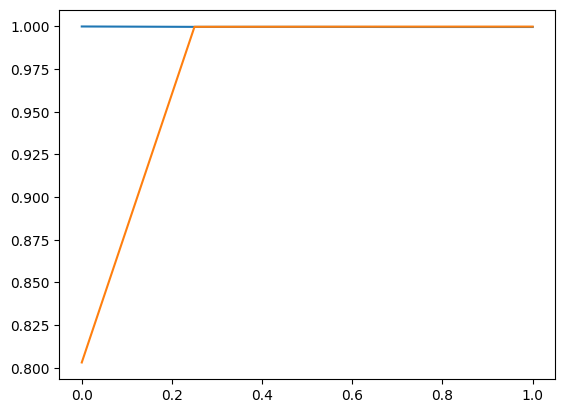

In [41]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, [y for _, y in y_softmax])
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, precision[:-1], label="Precision")

In [42]:
# Training accuracy
train_preds = dt_model.predict(X_train)
print("Training Accuracy:", sklearn.metrics.accuracy_score(y_train, train_preds))

# Test accuracy
test_preds = dt_model.predict(X_test)
print("Test Accuracy:", sklearn.metrics.accuracy_score(y_test, test_preds))

Training Accuracy: 0.9999681909928458
Test Accuracy: 0.9996896232971452
